In [3]:
import numpy as np
import matplotlib.pyplot as plt

totalExpected = 11.6+2.72
totalExpectedE = 2.8+0.02

toyExpCollection = []

for i in range(0,30000+1):

    expectedToy = np.random.normal(totalExpected, totalExpectedE)
    observedToyExp = np.random.poisson(expectedToy)
    
    toyExpCollection.append(observedToyExp)

    
binNumber = max(toyExpCollection) - min(toyExpCollection)

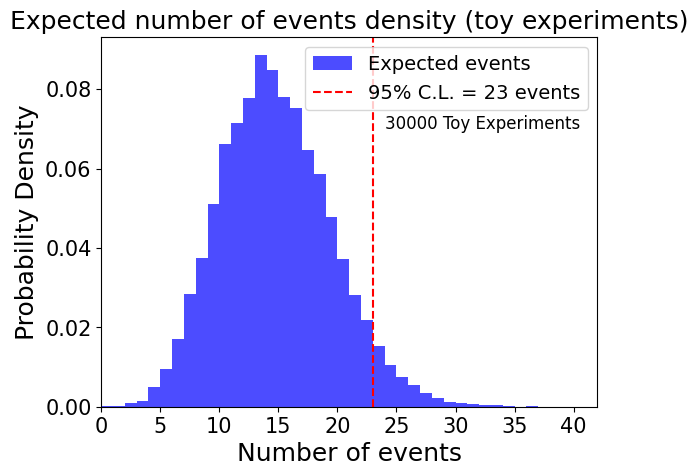

In [4]:
histogram = plt.hist(toyExpCollection, bins=binNumber, density=True, alpha=0.7, color='blue', label='Expected events')

# Add labels and a legend
plt.xlabel('Number of events',fontsize=18)
plt.ylabel('Probability Density',fontsize=18)
plt.title('Expected number of events density (toy experiments)',fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(0, 42)

plt.text(24,0.07,'30000 Toy Experiments', fontsize=12, color='black')

pdf = histogram[0]
CL95 = 0.95*np.sum(pdf)
limit = 0
for i in range(0,len(pdf)):
    if np.sum(pdf[0:i])>=CL95:
        limit = histogram[1][i]
        break

# Add a vertical line
vertical_line_x = limit  # x-coordinate where you want the vertical line
plt.axvline(x=vertical_line_x, color='red', linestyle='--', label='95% C.L. = '+str(int(limit))+ ' events')

plt.legend(fontsize = 14)

# Show the plot
plt.savefig('CL95.pdf',bbox_inches='tight')
plt.show()


# CLs method implementation
You have to activate conda Stats environment

In [ ]:
import pyhf
import numpy as np
import matplotlib.pyplot as plt
from pyhf.contrib.viz import brazil
import pandas as pd


signal_names = ['Signal200','Signal250','Signal300','Signal350','Signal400','Signal450','Signal500']
def construct_signal_array(pandas_df):
    signal_array = []
    for signal_sample in signal_names:
        signal_array.append(np.array(pandas_df[signal_sample]))

    return np.array(signal_array)

def merge_channels(channel_one_csv : str , channel_two_csv : str = None, method : str ='extend'):
    
    if method not in ['merge', 'extend']:
        raise ValueError("Method must be either 'merge' or 'extend'")
    
    # Load the first channel
    pd1 = pd.read_csv(channel_one_csv)
    bkg_array1 = np.array(pd1['Background'])
    bkg_error_array1 = np.array(pd1['BackgroundError'])
    signal_1_array = construct_signal_array(pd1)

    if channel_two_csv is None:
        # Create a dataframe with names of columns and data
        result_dic = {
            'Background': bkg_array1,
            'BackgroundError': bkg_error_array1,
        }
        for i, signal_name in enumerate(signal_names):
            result_dic[signal_name] = signal_1_array[i]
        result_df = pd.DataFrame(result_dic)
        result_df.to_csv('cls_inputs.csv', index=False)

    else:
        # Load the second channel
        pd2 = pd.read_csv(channel_two_csv)
        bkg_array2 = np.array(pd2['Background'])
        bkg_error_array2 = np.array(pd2['BackgroundError'])
        signal_2_array = construct_signal_array(pd2)

        # Merge the two channels
        if method == 'merge':
            bkg_array = bkg_array1 + bkg_array2
            bkg_error_array = np.sqrt(bkg_error_array1**2 + bkg_error_array2**2)
            signal_array = signal_1_array + signal_2_array

            # Save the merged data to a new CSV file
            result_dic = {
                'Background': bkg_array,
                'BackgroundError': bkg_error_array,
            }
            for i, signal_name in enumerate(signal_names):
                result_dic[signal_name] = signal_array[i]
            result_df = pd.DataFrame(result_dic)
            result_df.to_csv('cls_inputs.csv', index=False)

        elif method == 'extend':
            bkg_array = np.concatenate((bkg_array1, bkg_array2))
            bkg_error_array = np.concatenate((bkg_error_array1, bkg_error_array2))
            signal_array = np.concatenate((signal_1_array, signal_2_array), axis=1)

            # Save the extended data to a new CSV file
            result_dic = {
                'Background': bkg_array,
                'BackgroundError': bkg_error_array,
            }
            for i, signal_name in enumerate(signal_names):
                result_dic[signal_name] = signal_array[i]
            result_df = pd.DataFrame(result_dic)
            result_df.to_csv('cls_inputs.csv', index=False)


pyhf.set_backend("numpy")

channels_to_fit = ['CLsInputsHadHad.csv', 'CLsInputs.csv']
# Merge the channels
merge_channels(channels_to_fit[0], channels_to_fit[1], method='extend')
plot_title = 'TauTau'

pd = pd.read_csv('cls_inputs.csv')
bkg_array = np.array(pd['Background'])
bkg_error_array = np.array(pd['BackgroundError'])

xsec_list = 1000*np.array([0.052713, 0.019435, 0.009294, 0.005152, 0.003149, 0.002058, 0.001406])

In [35]:
expected_limits = {}
for signal_name in signal_names:
    # Declare model
    model = pyhf.simplemodels.uncorrelated_background(
        signal = np.array(pd[signal_name]) ,
        bkg = bkg_array,
        bkg_uncertainty = bkg_error_array,)
    # Set data to bkg expected for the time being
    data = list(bkg_array) + model.config.auxdata

    # Do the calculation
    scan = np.linspace(0, 3, 210)
    obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit( data, model, scan, return_results=True)
    expected_limits[signal_name] = exp_limits

In [36]:
expected_limits

{'Signal200': [array(0.01555256),
  array(0.02477077),
  array(0.03544987),
  array(0.05439954),
  array(0.08338923)],
 'Signal250': [array(0.04052508),
  array(0.05618478),
  array(0.08462128),
  array(0.13185674),
  array(0.2005577)],
 'Signal300': [array(0.05706486),
  array(0.08304803),
  array(0.12793427),
  array(0.20572843),
  array(0.32240172)],
 'Signal350': [array(0.09508444),
  array(0.13571358),
  array(0.20698725),
  array(0.32651864),
  array(0.5029333)],
 'Signal400': [array(0.15342832),
  array(0.21884015),
  array(0.33212302),
  array(0.51941694),
  array(0.79201374)],
 'Signal450': [array(0.21774913),
  array(0.31244031),
  array(0.47711158),
  array(0.75047767),
  array(1.1494504)],
 'Signal500': [array(0.30743581),
  array(0.43694626),
  array(0.66029699),
  array(1.02988022),
  array(1.56981897)]}

array([52.713, 19.435,  9.294,  5.152,  3.149,  2.058,  1.406])

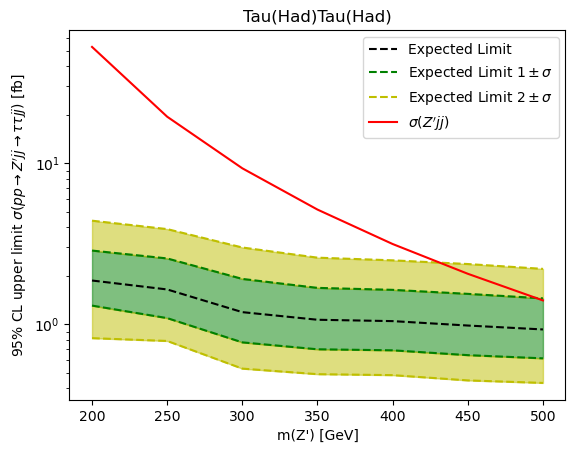

In [37]:
expected_line = []
sigma_p1_line = []
sigma_p2_line = []
sigma_m1_line = []
sigma_m2_line = []

for i in signal_names:
    expected_line.append(float(expected_limits[i][2]))
    sigma_p1_line.append(float(expected_limits[i][3]))
    sigma_p2_line.append(float(expected_limits[i][4]))
    sigma_m1_line.append(float(expected_limits[i][1]))
    sigma_m2_line.append(float(expected_limits[i][0]))

expected_line = np.array(xsec_list)*np.array(expected_line)
sigma_p1_line = np.array(xsec_list)*np.array(sigma_p1_line)
sigma_p2_line = np.array(xsec_list)*np.array(sigma_p2_line)
sigma_m1_line = np.array(xsec_list)*np.array(sigma_m1_line)
sigma_m2_line = np.array(xsec_list)*np.array(sigma_m2_line)

x_axis = np.linspace(200, 500, 7)
fig, ax = plt.subplots()
ax.plot(x_axis,expected_line,'k--',label='Expected Limit')
ax.plot(x_axis,sigma_p1_line,'g--',label=r'Expected Limit $1\pm\sigma$')
ax.plot(x_axis,sigma_m1_line,'g--')
ax.plot(x_axis,sigma_p2_line,'y--',label=r'Expected Limit $2\pm\sigma$')
ax.plot(x_axis,sigma_m2_line,'y--')
ax.plot(x_axis,xsec_list,'r-',label=r"$\sigma( Z'jj )$")
ax.set_title(plot_title)

ax.legend()

ax.set_yscale('log')
ax.set_xlabel(r"m(Z') [GeV]")
ax.set_ylabel(r"95% CL upper limit $\sigma(pp\to Z'jj\to \tau\tau jj)$ [fb]")

ax.fill_between(x_axis, sigma_m1_line, sigma_p1_line, alpha=0.5, color='g')
ax.fill_between(x_axis, sigma_m2_line, sigma_m1_line, alpha=0.5, color='y')
ax.fill_between(x_axis, sigma_p1_line, sigma_p2_line, alpha=0.5, color='y')
xsec_list

# 

/var/folders/vz/9jwsmzpn0d7g_dzz8znp1mzw0000gp/T/ipykernel_5013/321161548.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


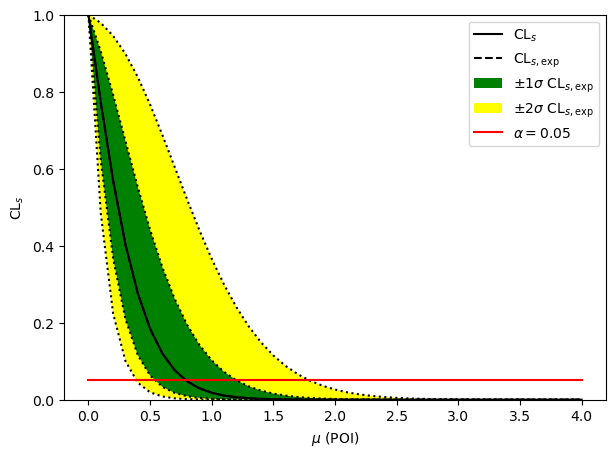

In [87]:
poi_vals = np.linspace(0, 4.0, 41)
results = [
    pyhf.infer.hypotest(
        test_poi, data, model, test_stat="qtilde", return_expected_set=True
    )
    for test_poi in poi_vals
]

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
brazil.plot_results(poi_vals, results, ax=ax)
fig.show()